# Train a basic TensorFlow Lite for Microcontrollers model
&copy; 2020 by Michael Stanley (Mike.Stanley@ieee.org)<BR>
Last revised: 26 July 2020

This notebook demonstrates the process of training a model using TensorFlow and converting it for use with TensorFlow Lite for Microcontrollers. 

The model in question accepts a 1x2 vector containing normalaized sensor samples and converts this to a one-hot encoding of 0|1|2|3, which corresponds to fan off, low, medium and high for an example embedded ML problem.

The model was derived from the standard Tensorflow-Lite [hello_world] example, but has been heavily modified.

Reference: (https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/hello_world) example for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview).


# Import dependencies and set random number seeds

In [1]:
import os
import numpy as np
np.random.seed(1) # numpy seed
import tensorflow as tf
tf.random.set_seed(1) # tensorflow global random seed
from tensorflow import keras # Keras is TensorFlow's high-level API for deep learning
import matplotlib.pyplot as plt # Matplotlib is a graphing library
import math # Math is Python's math library
import pandas as pd
from sklearn import metrics
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# set default font for charts
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

# Subroutine for XY plots: myScatter()
This utility function can create an XY plot of two features found in the input table.  We use it here to reproduce a figure originally created by the Feature_Extraction_Using_Pandas notebook used to create our test features.csv.

This particular function works with numpy arrays only.  Contrast that with myScatterPandas (found in other notebooks in this series) which expects a Pandas dataframe as input.  Because we're using numpy arrays, feature names are lost, so you will see feature0 and feature1 as the feature labels, instead of the actual feature names.

In [3]:
def myScatter(X, idx0, idx1, Y):
    labels=['Off', 'Low', 'Medium', 'High']
    color = ['black', 'green', 'blue', 'red']
    fig, ax = plt.subplots()
    x0 = X[:,idx0]
    x1 = X[:,idx1]
    for g in np.unique(Y):
        ix = np.where(g==Y)
        c=color[g]
        ax.scatter(x0[ix], x1[ix], c=c, label=labels[g])
    plt.legend(loc='best', frameon=False, labels=['Off', 'Low', 'Medium', 'High'])
    plt.xlabel('feature'+str(idx0))
    plt.ylabel('feature'+str(idx1))

# Dataset

## Import Data
This notebook consumes features.csv, which is the same file consumed by Feature_Selection.ipynb and Simple_Classification.ipynb.

In [4]:
fn = 'features.csv'
data = pd.read_csv(fn)
print('Data shape retreived from the features data file is: ', str(data.shape))

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

display(data.head())

Data shape retreived from the features data file is:  (262, 33)


,maxAudio_max,acc_max,mag_max,gyro_max,maxAudio_min,acc_min,mag_min,gyro_min,maxAudio_skew,acc_skew,...,gyro_mean,maxAudio_std,acc_std,mag_std,gyro_std,maxAudio_var,acc_var,mag_var,gyro_var,class
0,225.0,0.99981,78.0197,4.81369,39.0,0.998642,76.8871,4.48577,2.363250,0.297388,...,4.63669,59.1439,0.000381,0.373034,0.111463,3498.000,1.448700e-07,0.139155,0.012424,0.0
1,361.0,1.10354,196.0540,4.88087,279.0,0.900920,54.6311,4.41811,-0.551375,-0.167078,...,4.65471,27.7704,0.069195,57.622400,0.187195,771.194,4.787910e-03,3320.340000,0.035042,3.0
2,182.0,1.05192,174.4250,4.94681,123.0,0.945176,60.1111,4.36236,0.916592,-0.156168,...,4.59955,19.5604,0.040884,41.267100,0.186153,382.611,1.671500e-03,1702.970000,0.034653,1.0
3,175.0,1.05976,157.9990,4.86021,114.0,0.950328,53.5160,4.10396,0.357268,0.061186,...,4.56585,17.8567,0.040005,34.160500,0.271288,318.861,1.600430e-03,1166.940000,0.073597,1.0
4,69.0,1.00064,77.8804,4.83679,-1.0,0.998912,77.0469,4.46092,0.549834,0.109891,...,4.65760,25.8656,0.000559,0.252523,0.127875,669.028,3.125200e-07,0.063768,0.016352,0.0


As usual, let's plot the selected features to confirm that they match what we've seen in other notebooks.

Total number of samples =  262
Unnormalized input data


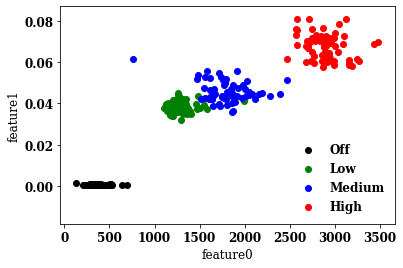

In [5]:
f2 = 'acc_std'
f1 = 'maxAudio_sum'
# Split out features and class membership into separate tables.
x_values = data[[f1, f2]].to_numpy()
y_values=data['class'].astype(int).to_numpy()
num_samples, cols = x_values.shape
print('Total number of samples = ', num_samples)
print('Unnormalized input data')
myScatter(x_values, 0, 1, y_values)

## Split the data and then normalize it

To evaluate the accuracy of the model we train, we'll need to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation) and after training (referred to as testing).  This particular model replicates an experiment already done using scikit-learn, so we're only doing a two-way split to check for consistency with earlier results.

The data is split as follows:
  1. Training: 66%
  2. Testing: 34% 

The following code will split our data and then plot each set as a different color:

Normalized training data
Normalized test data


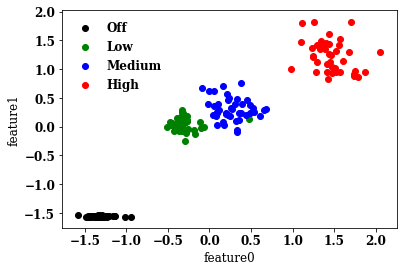

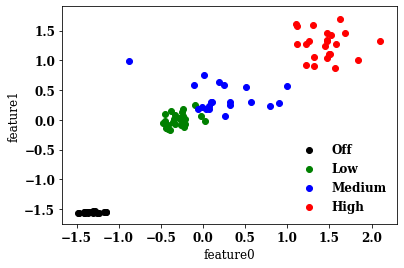

In [6]:
x_values = x_values.astype(np.float32)
split_pt = int(0.66*num_samples)
x_train, x_test = np.split(x_values, [split_pt])
y_train, y_test = np.split(y_values, [split_pt])

mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

x_train = (x_train - mean)/std
x_test  = (x_test  - mean)/std

print('Normalized training data')
myScatter(x_train, 0, 1, y_train)
print('Normalized test data')
myScatter(x_test, 0, 1, y_test)


# Design the model
We're going to build a simple neural network model that will take a two-feature input value and use it to predict 1 of 4 class membership. 

**Note:** To learn more about how neural networks function, you can explore the [Learn TensorFlow](https://codelabs.developers.google.com/codelabs/tensorflow-lab1-helloworld) codelabs.

The code in the following cell defines our model using [Keras](https://www.tensorflow.org/guide/keras), TensorFlow's high-level API for creating deep learning networks. Once the network is defined, we _compile_ it, specifying parameters that determine how it will be trained:

In [7]:
# We'll use Keras to create a simple model architecture
model_1 = tf.keras.Sequential()

# First layer takes a two scalar input and feeds it through 4 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_1.add(keras.layers.Dense(4, activation='relu', input_shape=(2,)))

# Final layer is a single neuron, since we want to output a single value
model_1.add(keras.layers.Dense(4, activation=tf.nn.softmax))

# Compile the model using a standard optimizer and loss function for regression
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
Once we've defined the model, we can use our data to _train_ it. Training involves passing an `x` value into the neural network, checking how far the network's output deviates from the expected `y` value, and adjusting the neurons' weights and biases so that the output is more likely to be correct the next time.

Training runs this process on the full dataset multiple times, and each full run-through is known as an <b>epoch</b>. The number of epochs to run during training is a parameter we can set.

During each epoch, data is run through the network in multiple _batches_. In each batch, several pieces of data are passed into the network, producing output values. These outputs' correctness is measured in aggregate and the network's weights and biases are adjusted accordingly, once per batch. The _batch size_ is also a parameter we can set.

The code in the following cell uses the `x` and `y` values from our training data to train the model. It runs for 500 _epochs_, with 25 pieces of data in each _batch_. We also pass in some data for _validation_. As you will see when you run the cell, training can take a while to complete:



In [8]:
one_hot_ytrain = np_utils.to_categorical(y_train)
one_hot_ytest = np_utils.to_categorical(y_test)

In [9]:
# Train the model on our training data while validating on our test set
history_1 = model_1.fit(x_train, one_hot_ytrain, epochs=500, batch_size=25, validation_data=(x_test, one_hot_ytest))

Train on 172 samples, validate on 90 samples
Epoch 1/500
172/172 [==============================] - 1s 6ms/sample - loss: 1.4513 - accuracy: 0.1395 - val_loss: 1.4348 - val_accuracy: 0.2556
Epoch 2/500
172/172 [==============================] - 0s 232us/sample - loss: 1.4312 - accuracy: 0.2209 - val_loss: 1.4145 - val_accuracy: 0.3000
Epoch 3/500
172/172 [==============================] - 0s 250us/sample - loss: 1.4112 - accuracy: 0.2616 - val_loss: 1.3949 - val_accuracy: 0.3000
Epoch 4/500
172/172 [==============================] - 0s 273us/sample - loss: 1.3919 - accuracy: 0.2733 - val_loss: 1.3758 - val_accuracy: 0.3111
Epoch 5/500
172/172 [==============================] - 0s 238us/sample - loss: 1.3731 - accuracy: 0.2791 - val_loss: 1.3573 - val_accuracy: 0.3333
Epoch 6/500
172/172 [==============================] - 0s 215us/sample - loss: 1.3554 - accuracy: 0.3081 - val_loss: 1.3392 - val_accuracy: 0.3333
Epoch 7/500
172/172 [==============================] - 0s 267us/sample - lo

172/172 [==============================] - 0s 192us/sample - loss: 0.7427 - accuracy: 0.8895 - val_loss: 0.7363 - val_accuracy: 0.8667
Epoch 57/500
172/172 [==============================] - 0s 174us/sample - loss: 0.7350 - accuracy: 0.9070 - val_loss: 0.7290 - val_accuracy: 0.8778
Epoch 58/500
172/172 [==============================] - 0s 174us/sample - loss: 0.7275 - accuracy: 0.9070 - val_loss: 0.7218 - val_accuracy: 0.8778
Epoch 59/500
172/172 [==============================] - 0s 174us/sample - loss: 0.7201 - accuracy: 0.9186 - val_loss: 0.7148 - val_accuracy: 0.8778
Epoch 60/500
172/172 [==============================] - 0s 221us/sample - loss: 0.7128 - accuracy: 0.9244 - val_loss: 0.7080 - val_accuracy: 0.8778
Epoch 61/500
172/172 [==============================] - 0s 349us/sample - loss: 0.7057 - accuracy: 0.9244 - val_loss: 0.7012 - val_accuracy: 0.8778
Epoch 62/500
172/172 [==============================] - 0s 215us/sample - loss: 0.6986 - accuracy: 0.9244 - val_loss: 0.6946 

172/172 [==============================] - 0s 168us/sample - loss: 0.4488 - accuracy: 0.9884 - val_loss: 0.4580 - val_accuracy: 0.9667
Epoch 112/500
172/172 [==============================] - 0s 169us/sample - loss: 0.4450 - accuracy: 0.9884 - val_loss: 0.4543 - val_accuracy: 0.9667
Epoch 113/500
172/172 [==============================] - 0s 192us/sample - loss: 0.4411 - accuracy: 0.9884 - val_loss: 0.4507 - val_accuracy: 0.9667
Epoch 114/500
172/172 [==============================] - 0s 180us/sample - loss: 0.4373 - accuracy: 0.9884 - val_loss: 0.4471 - val_accuracy: 0.9667
Epoch 115/500
172/172 [==============================] - 0s 174us/sample - loss: 0.4334 - accuracy: 0.9884 - val_loss: 0.4436 - val_accuracy: 0.9667
Epoch 116/500
172/172 [==============================] - 0s 180us/sample - loss: 0.4298 - accuracy: 0.9884 - val_loss: 0.4400 - val_accuracy: 0.9667
Epoch 117/500
172/172 [==============================] - 0s 180us/sample - loss: 0.4259 - accuracy: 0.9884 - val_loss: 0

172/172 [==============================] - 0s 174us/sample - loss: 0.2804 - accuracy: 0.9942 - val_loss: 0.3023 - val_accuracy: 0.9556
Epoch 167/500
172/172 [==============================] - 0s 192us/sample - loss: 0.2779 - accuracy: 0.9942 - val_loss: 0.3002 - val_accuracy: 0.9667
Epoch 168/500
172/172 [==============================] - 0s 198us/sample - loss: 0.2756 - accuracy: 0.9942 - val_loss: 0.2981 - val_accuracy: 0.9667
Epoch 169/500
172/172 [==============================] - 0s 186us/sample - loss: 0.2734 - accuracy: 0.9942 - val_loss: 0.2960 - val_accuracy: 0.9667
Epoch 170/500
172/172 [==============================] - 0s 186us/sample - loss: 0.2711 - accuracy: 0.9942 - val_loss: 0.2940 - val_accuracy: 0.9667
Epoch 171/500
172/172 [==============================] - 0s 186us/sample - loss: 0.2689 - accuracy: 0.9942 - val_loss: 0.2920 - val_accuracy: 0.9667
Epoch 172/500
172/172 [==============================] - 0s 180us/sample - loss: 0.2667 - accuracy: 0.9942 - val_loss: 0

172/172 [==============================] - 0s 261us/sample - loss: 0.1832 - accuracy: 0.9942 - val_loss: 0.2142 - val_accuracy: 0.9667
Epoch 222/500
172/172 [==============================] - 0s 261us/sample - loss: 0.1818 - accuracy: 0.9942 - val_loss: 0.2132 - val_accuracy: 0.9667
Epoch 223/500
172/172 [==============================] - 0s 203us/sample - loss: 0.1805 - accuracy: 0.9942 - val_loss: 0.2121 - val_accuracy: 0.9667
Epoch 224/500
172/172 [==============================] - 0s 215us/sample - loss: 0.1793 - accuracy: 0.9942 - val_loss: 0.2109 - val_accuracy: 0.9667
Epoch 225/500
172/172 [==============================] - 0s 180us/sample - loss: 0.1782 - accuracy: 0.9942 - val_loss: 0.2098 - val_accuracy: 0.9667
Epoch 226/500
172/172 [==============================] - 0s 192us/sample - loss: 0.1769 - accuracy: 0.9942 - val_loss: 0.2087 - val_accuracy: 0.9667
Epoch 227/500
172/172 [==============================] - 0s 186us/sample - loss: 0.1756 - accuracy: 0.9942 - val_loss: 0

172/172 [==============================] - 0s 168us/sample - loss: 0.1303 - accuracy: 0.9942 - val_loss: 0.1668 - val_accuracy: 0.9667
Epoch 277/500
172/172 [==============================] - 0s 174us/sample - loss: 0.1296 - accuracy: 0.9942 - val_loss: 0.1662 - val_accuracy: 0.9667
Epoch 278/500
172/172 [==============================] - 0s 180us/sample - loss: 0.1289 - accuracy: 0.9942 - val_loss: 0.1655 - val_accuracy: 0.9667
Epoch 279/500
172/172 [==============================] - 0s 180us/sample - loss: 0.1282 - accuracy: 0.9942 - val_loss: 0.1649 - val_accuracy: 0.9667
Epoch 280/500
172/172 [==============================] - 0s 174us/sample - loss: 0.1276 - accuracy: 0.9942 - val_loss: 0.1643 - val_accuracy: 0.9667
Epoch 281/500
172/172 [==============================] - 0s 209us/sample - loss: 0.1269 - accuracy: 0.9942 - val_loss: 0.1637 - val_accuracy: 0.9667
Epoch 282/500
172/172 [==============================] - 0s 238us/sample - loss: 0.1262 - accuracy: 0.9942 - val_loss: 0

172/172 [==============================] - 0s 180us/sample - loss: 0.1013 - accuracy: 0.9942 - val_loss: 0.1406 - val_accuracy: 0.9667
Epoch 332/500
172/172 [==============================] - 0s 186us/sample - loss: 0.1010 - accuracy: 0.9942 - val_loss: 0.1401 - val_accuracy: 0.9667
Epoch 333/500
172/172 [==============================] - 0s 163us/sample - loss: 0.1006 - accuracy: 0.9942 - val_loss: 0.1400 - val_accuracy: 0.9667
Epoch 334/500
172/172 [==============================] - 0s 192us/sample - loss: 0.1002 - accuracy: 0.9942 - val_loss: 0.1396 - val_accuracy: 0.9667
Epoch 335/500
172/172 [==============================] - 0s 291us/sample - loss: 0.0998 - accuracy: 0.9942 - val_loss: 0.1393 - val_accuracy: 0.9667
Epoch 336/500
172/172 [==============================] - 0s 285us/sample - loss: 0.0994 - accuracy: 0.9942 - val_loss: 0.1389 - val_accuracy: 0.9667
Epoch 337/500
172/172 [==============================] - 0s 209us/sample - loss: 0.0991 - accuracy: 0.9942 - val_loss: 0

172/172 [==============================] - 0s 192us/sample - loss: 0.0849 - accuracy: 0.9942 - val_loss: 0.1256 - val_accuracy: 0.9667
Epoch 387/500
172/172 [==============================] - 0s 186us/sample - loss: 0.0847 - accuracy: 0.9942 - val_loss: 0.1253 - val_accuracy: 0.9667
Epoch 388/500
172/172 [==============================] - 0s 192us/sample - loss: 0.0845 - accuracy: 0.9942 - val_loss: 0.1251 - val_accuracy: 0.9667
Epoch 389/500
172/172 [==============================] - 0s 169us/sample - loss: 0.0842 - accuracy: 0.9942 - val_loss: 0.1248 - val_accuracy: 0.9667
Epoch 390/500
172/172 [==============================] - 0s 203us/sample - loss: 0.0840 - accuracy: 0.9942 - val_loss: 0.1248 - val_accuracy: 0.9667
Epoch 391/500
172/172 [==============================] - 0s 192us/sample - loss: 0.0838 - accuracy: 0.9942 - val_loss: 0.1245 - val_accuracy: 0.9667
Epoch 392/500
172/172 [==============================] - 0s 186us/sample - loss: 0.0836 - accuracy: 0.9942 - val_loss: 0

Epoch 441/500
172/172 [==============================] - 0s 198us/sample - loss: 0.0751 - accuracy: 0.9942 - val_loss: 0.1159 - val_accuracy: 0.9667
Epoch 442/500
172/172 [==============================] - 0s 168us/sample - loss: 0.0750 - accuracy: 0.9942 - val_loss: 0.1158 - val_accuracy: 0.9667
Epoch 443/500
172/172 [==============================] - 0s 186us/sample - loss: 0.0748 - accuracy: 0.9942 - val_loss: 0.1156 - val_accuracy: 0.9667
Epoch 444/500
172/172 [==============================] - 0s 186us/sample - loss: 0.0747 - accuracy: 0.9942 - val_loss: 0.1154 - val_accuracy: 0.9667
Epoch 445/500
172/172 [==============================] - 0s 186us/sample - loss: 0.0745 - accuracy: 0.9942 - val_loss: 0.1153 - val_accuracy: 0.9667
Epoch 446/500
172/172 [==============================] - 0s 180us/sample - loss: 0.0744 - accuracy: 0.9942 - val_loss: 0.1154 - val_accuracy: 0.9667
Epoch 447/500
172/172 [==============================] - 0s 192us/sample - loss: 0.0743 - accuracy: 0.9942

Epoch 496/500
172/172 [==============================] - 0s 174us/sample - loss: 0.0689 - accuracy: 0.9942 - val_loss: 0.1092 - val_accuracy: 0.9667
Epoch 497/500
172/172 [==============================] - 0s 203us/sample - loss: 0.0688 - accuracy: 0.9942 - val_loss: 0.1091 - val_accuracy: 0.9667
Epoch 498/500
172/172 [==============================] - 0s 186us/sample - loss: 0.0688 - accuracy: 0.9942 - val_loss: 0.1091 - val_accuracy: 0.9667
Epoch 499/500
172/172 [==============================] - 0s 168us/sample - loss: 0.0687 - accuracy: 0.9942 - val_loss: 0.1089 - val_accuracy: 0.9667
Epoch 500/500
172/172 [==============================] - 0s 180us/sample - loss: 0.0686 - accuracy: 0.9942 - val_loss: 0.1088 - val_accuracy: 0.9667


# Plot metrics

## Loss vs Epoch
Draw a graph of the loss, which is the distance between
the predicted and actual values during training and validation.

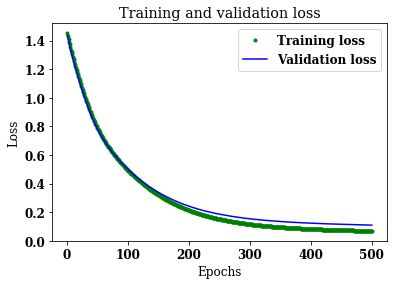

In [10]:
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The graph shows the _loss_ (or the difference between the model's predictions and the actual data) for each epoch. There are several ways to calculate loss, and the method we have used is _categorical_crossentropy_. There is a distinct loss value given for the training and the validation data.

As we can see, the amount of loss initially rapidly decreases, before flattening out. This means that the model is improving and producing more accurate predictions!

## Accuracy vs Epoch

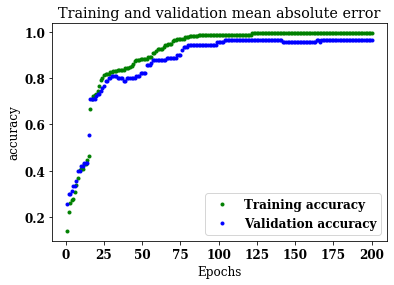

In [11]:
plt.clf()
# Draw a graph of accuracy.
accuracy = history_1.history['accuracy']
val_accuracy = history_1.history['val_accuracy']
SKIP=200
plt.plot(epochs[:SKIP], accuracy[:SKIP], 'g.', label='Training accuracy')
plt.plot(epochs[:SKIP], val_accuracy[:SKIP], 'b.', label='Validation accuracy')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Confusion matrix

Confusion matrix for the training set


array([[21,  0,  0,  0],
       [ 0, 26,  0,  0],
       [ 0,  2, 17,  1],
       [ 0,  0,  0, 23]], dtype=int64)

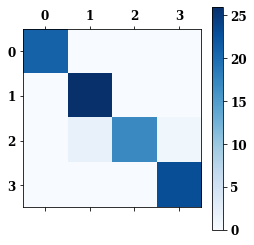

In [12]:
print('Confusion matrix for the training set')
predictions = model_1.predict(x_test)
predictions = np.argmax(predictions, axis=1)
cm=metrics.confusion_matrix(y_test, predictions, labels=None)
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
cm

# Generate a TensorFlow Lite model

## Generate model without quantization
It is possible to quantize a model to reduce it's size.  To keep this example simple, we'll skip that step.

In [13]:
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
#MODEL_TF = MODELS_DIR + 'model.pb'
#MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_TEMP = MODELS_DIR + 'model.temp'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.ccp'

In [14]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
model_tflite = converter.convert()

# # Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

1360

## Look at the model size

In [15]:
import os
model_no_quant_size = os.path.getsize(MODEL_TFLITE)
print("Model is %d bytes" % model_no_quant_size)
print('Model location is:', MODEL_TFLITE)

Model is 1360 bytes
Model location is: models/model.tflite


### 3. Test the models

To prove these models are still accurate after conversion and quantization, we'll use both of them to make predictions and compare these against our test results:

In [16]:
# Instantiate an interpreter
model_2 = tf.lite.Interpreter(MODEL_TFLITE) # read back in the file we saved earlier

# Allocate memory for each model
model_2.allocate_tensors()

input_details = model_2.get_input_details()
output_details = model_2.get_output_details()

# Get the input and output tensors so we can feed in values and get the results
input = model_2.tensor(input_details[0]["index"])
output = model_2.tensor(output_details[0]["index"])

# Create arrays to store the results
tfl_predictions = np.empty(y_test.shape)
#model_predictions = np.empty(x_test.size)

# Run each model's interpreter for each value and store the results in arrays
for i in range(x_test.shape[0]):
  input()[0]=x_test[i].reshape([1,2])[0]
  model_2.invoke()
  tfl_predictions[i] = np.argmax(output()[0])

array([[21,  0,  0,  0],
       [ 0, 26,  0,  0],
       [ 0,  2, 17,  1],
       [ 0,  0,  0, 23]], dtype=int64)

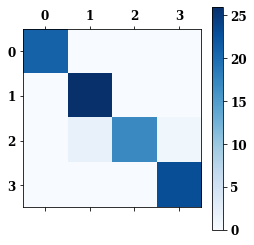

In [17]:
cm=metrics.confusion_matrix(y_test, tfl_predictions, labels=None)
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
cm

We can see from the confusion matrix that the model is ready to use.

## Generate a TensorFlow Lite for Microcontrollers model
Convert the TensorFlow Lite quantized model into a C++ source file that can be loaded by TensorFlow Lite for Microcontrollers.  The original "hello_world" for TinyML used Linux xxd and sed commands to translate the file.
We found a Windows version of xxd.exe as part of the [GVIM distribution](https://www.vim.org/).  Look in the VIM installation
directory and copy xxd.exe to your Jupyter working directory if it is not already there.  The sed call has been replaced with equivalent
Python Code.

The output format has been modified to specifically match up with Arduino Nano 33 BLE Sense "fanDemo" example.

In [18]:
# Install xxd if it is not available
#!apt-get update && apt-get -qq install xxd 

# Convert to a C source file
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_TEMP}

# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
#!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}  # This is the original Linux sed call
with open(MODEL_TFLITE_TEMP, 'rt') as fin:
    with open(MODEL_TFLITE_MICRO, 'wt', encoding='utf-8') as fout:
        fout.write('const float means[] = {{ {0}, {1} }};\n'.format(mean[0], mean[1]))
        fout.write('const float stds[] = {{ {0}, {1} }};\n'.format(std[0], std[1]))
        for line in fin:
            newLine = line.replace('unsigned char', 'const unsigned char')
            newLine = newLine.replace(REPLACE_TEXT, 'fandemo_model_data')
            newLine = newLine.replace('fandemo_model_data[]', 'fandemo_model_data[] DATA_ALIGN_ATTRIBUTE')
            newLine = newLine.replace('unsigned int', 'const unsigned int')
            fout.write(newLine)
os.remove(MODEL_TFLITE_TEMP)
print('TensorFlow output file = ', MODEL_TFLITE_MICRO)

TensorFlow output file =  models/model.ccp


## Deploy to a microcontroller

The original [hello_world](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/hello_world) README.md for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview) contained instructions to deploy models on a specific microcontroller.

Our example has already been optimized for use with the Arduino Nano 33 BLE Sense "fanDemo" example.  Simply overwrite models/model.cpp onto fandemo/model.cpp.

In [19]:
with open(MODEL_TFLITE_MICRO, 'rt') as fin:
    for line in fin:
        print(line.replace('\n',''))

const float means[] = { 1566.2384033203125, 0.037772245705127716 };
const float stds[] = { 912.6927490234375, 0.02383682131767273 };
const unsigned char fandemo_model_data[] DATA_ALIGN_ATTRIBUTE = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x12, 0x00,
  0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00,
  0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x00, 0x05, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x2c, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0xc4, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x8c, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x54, 0x4f, 0x43, 0x4f, 0x20, 0x43, 0x6f, 0x6e,
  0x76, 0x65, 0x72, 0x74, 0x65, 0x64, 0x2e, 0x00, 0x0a, 0x00, 0x00, 0x00,
  0x60, 0x00, 0x00, 0x00, 0x58, 0x00, 0x00, 0x00, 0x4c, 0x00, 0x00, 0x00,
  0x44, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00, 0x34, 0x00, 0x00, 0x00,
  0x28, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x10, 0x00,

Note that the TensorFlow Lite standard examples do not include normalization parameters <b>means</b> and <b>stds</b>, as they are focused only on the TensorFlow components of the problem.  But with real-life sensor-based applications, it is important to normalize new data feeding the deployed model.  That normalization MUST match that used to train the model.  It really should be considered to be part of the model, and that is why we automate its inclusion in this flow.  Look in the C++ code in Lab A3 to see how these are consumed. 